In [150]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

In [151]:
torch.cuda.empty_cache()

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [153]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050 Ti'

In [154]:

torch.cuda.set_device(0)

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [155]:
X = torch.linspace(-20, 20, 1000)
Y = torch.sin(X)

X_ = torch.linspace(-10, 10, 300)
Y_ = torch.sin(X_)

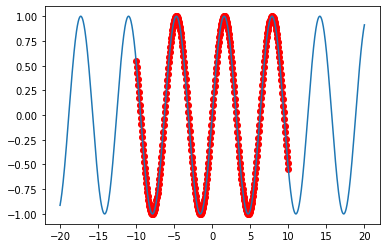

In [156]:
plt.plot(X.cpu(), Y.cpu(), label='sin(x)')
plt.scatter(X_.cpu(), Y_.cpu(), c='r')

In [157]:
class SnakeActivation(nn.Module):
    '''
    defines the snake activation function with learnable parameter a
    and returns x + (1/a)* sin^2(ax) 
    '''
    def __init__(self, alpha, in_features):
        super(SnakeActivation, self).__init__()
        self.alpha = alpha
        self.in_features = in_features
        self.a = nn.Parameter(
            torch.ones(self.in_features) * self.alpha, requires_grad=True
            )

    
    def snake(self, x):
        return x + (1/self.a)*torch.pow(torch.sin(self.a* (x)), 2)

    def forward(self, x):
        return self.snake(x)

        
    

In [158]:
class FeedForwardModel(nn.Module):
    def __init__(self, act=nn.ReLU()):
        super(FeedForwardModel, self).__init__()
        
        self.linear1 = nn.Linear(1, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 256)
        self.linear4 = nn.Linear(256, 1)

        self.ac1 = SnakeActivation(alpha=3, in_features=256)
        self.ac2 = SnakeActivation(alpha=5, in_features=256)
        self.ac3 = SnakeActivation(alpha=3, in_features=256)

    def forward(self, x):
        x = x.view(1, 1)
        x = self.ac1(self.linear1(x))
        x = self.ac2(self.linear2(x))
        x = self.ac3(self.linear3(x))
        x = self.linear4(x)
        return x

In [159]:
ff = FeedForwardModel(act=SnakeActivation)

In [160]:
ff

FeedForwardModel(
  (linear1): Linear(in_features=1, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=1, bias=True)
  (ac1): SnakeActivation()
  (ac2): SnakeActivation()
  (ac3): SnakeActivation()
)

In [161]:
class DataLoader():
    ''' 
    has __init__ ,__len__ and __get_item__ 
    returns a batch of data of size batch_size
    '''
    def __init__(self, X, Y, batch_size=32):
        self.X = X.view(-1, 1)
        self.Y = Y.view(-1, 1)
        self.batch_size = batch_size
        self.n_batches = len(X)//batch_size
        
    
    def __len__(self):
        return self.n_batches
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]
  

In [162]:
dl = DataLoader(X_, Y_, batch_size=1)

In [163]:
dl

In [164]:
loss_fn = nn.SmoothL1Loss()

In [165]:
optim = torch.optim.SGD(ff.parameters(), lr=0.0001)

In [166]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X).view(1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if torch.isnan(ff.ac1.a).any():
            print('nan')
            break
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


loss: 0.062345  [    0/  300]
loss: 0.000197  [  100/  300]
loss: 0.011965  [  200/  300]


/var/data/python/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/var/data/python/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


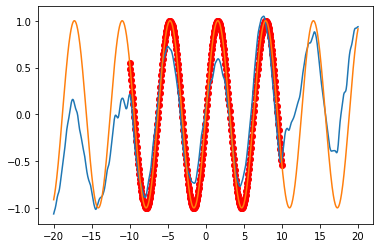

In [196]:
train_loop(dl, ff, loss_fn, optim)
pred = [ff(i).detach().cpu() for i in X]
plt.plot(X.detach().cpu().numpy(), pred, label='pred')
plt.plot(X.detach().cpu().numpy(), Y.detach().cpu().numpy(), label='true')
plt.scatter(X_.cpu(), Y_.cpu(), c='r')


/var/data/python/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/var/data/python/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


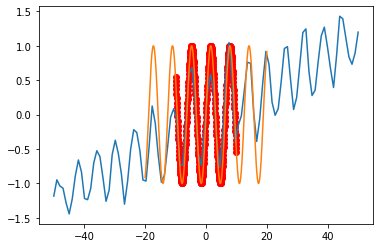

In [197]:
import numpy as np
pred = [ff(i).detach().cpu() for i in torch.linspace(-50, 50, 100)]
plt.plot( np.linspace(-50, 50, 100), pred, label='pred')
plt.plot(X.detach().cpu().numpy(), Y.detach().cpu().numpy(), label='true')
plt.scatter(X_.cpu(), Y_.cpu(), c='r')